In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import get_cmap
import os
import sys
import warnings
warnings.filterwarnings("ignore")

from sklearn import preprocessing
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

In [2]:
slice_name_list = ["E16.5_E1S1", "E15.5_E1S2", "E14.5_E1S1", "E13.5_E1S3",
                   "E12.5_E1S1", "E11.5_E1S1", "E10.5_E2S1", "E9.5_E1S1"]
preprocessed_data_path = "examples/mouse_embryo_stereoseq/run_inspire/preprocessed_data"

n_slices = len(slice_name_list)
loc_list = []
for i in range(n_slices):
    # Load data
    print("Load data", slice_name_list[i])
    adata = sc.read_h5ad(os.path.join(preprocessed_data_path, "raw_counts/"+slice_name_list[i]+".h5ad"))
    loc_list.append(adata.obsm["spatial"])

Load data E16.5_E1S1
Load data E15.5_E1S2
Load data E14.5_E1S1
Load data E13.5_E1S3
Load data E12.5_E1S1
Load data E11.5_E1S1
Load data E10.5_E2S1
Load data E9.5_E1S1


In [3]:
min_concat_dist = 20.

loc_list_new = [loc_list[0].copy()]
for i in range(n_slices):
    # Re-calculate spatial locations
    if i > 0:
        xmin_1 = np.min(loc_list[i-1][:,0])
        xmin_2 = np.min(loc_list[i][:,0])
        xmax_2 = np.max(loc_list[i][:,0])
        ymax_1 = np.max(loc_list[i-1][:,1])
        ymax_2 = np.max(loc_list[i][:,1])
        loc_list[i][:,0] = loc_list[i][:,0] - xmin_2 + xmin_1 - (xmax_2 - xmin_2 + min_concat_dist)
        loc_list[i][:,1] = loc_list[i][:,1] + (ymax_1 - ymax_2)
loc_full = np.concatenate([loc_list[i] for i in range(n_slices)], axis=0)

### Load results

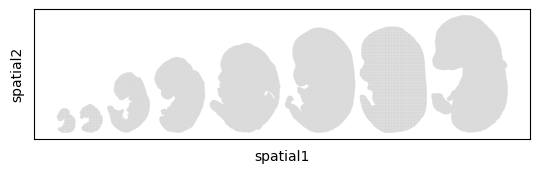

In [4]:
res_path = "Results/INSPIRE_developmental_stages"
adata = sc.read_h5ad(res_path + "/adata_inspire.h5ad")
adata.obsm["spatial"] = loc_full
sc.pl.spatial(adata, spot_size=1)

### Spatial distribution of the spatial factor related to smooth muscle cells in embryos

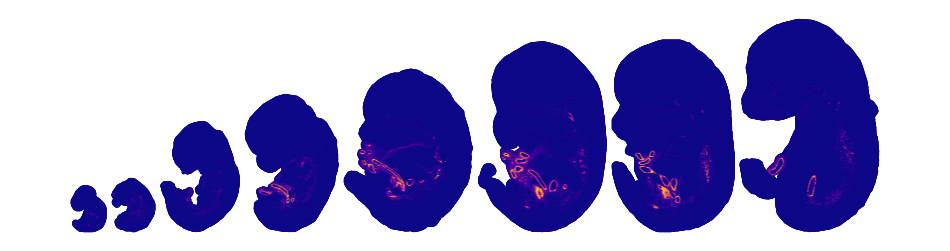

In [5]:
size = 2

f = plt.figure(figsize=(12,3))
ax = f.add_subplot(1,1,1)
ax.axis('equal')
pt = ax.scatter(adata.obsm["spatial"][:, 0], -adata.obsm["spatial"][:, 1], s=size, rasterized=True, 
                c=adata.obs["Proportion of spatial factor 21"], cmap="plasma", vmax=1)
ax.set_axis_off()
plt.show()

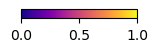

In [6]:
fig,ax = plt.subplots(figsize=(1.5,2))
cbar = plt.colorbar(pt, ax=ax, shrink=1., aspect=13, orientation='horizontal')
cbar.ax.tick_params(labelsize=10, rotation=0)
ax.remove()

In [7]:
res_path = "Results/INSPIRE_developmental_stages"
basis_df = pd.read_csv(res_path + "/basis_df_inspire.csv", index_col=0)

In [8]:
factor_id = 20

factor_profile = np.array(basis_df.iloc[factor_id,:].values)
order = np.argsort(-factor_profile)

potential_marker = list(basis_df.columns[order[:50]])
marker_ours = []
for i in range(len(potential_marker)):
    id_1 = np.argsort(-basis_df[potential_marker[i]])[0]
    id_2 = np.argsort(-basis_df[potential_marker[i]])[1]
    val_1 = basis_df[potential_marker[i]][id_1]
    val_2 = basis_df[potential_marker[i]][id_2]
    if (id_1 == factor_id) & (val_1 >= (val_2*1.)):
        marker_ours.append(potential_marker[i])

marker_ours_0 = marker_ours
print("Highly expressed genes associated with factor that characterize smooth muscle cells are:")
print(marker_ours)

Highly expressed genes associated with factor that characterize smooth muscle cells are:
['Acta2', 'Myl9', 'Tagln', 'Cnn2', 'Cnn1', 'Synpo2', 'Lsp1', 'Myocd', 'Mrvi1', 'Aldh1a1', 'Upk3b', 'Cald1', 'Crispld2', 'Sntg2', 'Chrm2', 'Rbpms', 'Colec10', 'Nkx2-3', 'Meis2', 'Meis1', 'Prkg1', 'Pgm5', 'Ano1', 'Kcnk3', 'Pde1a', 'Mab21l2', 'Gna14']


In [9]:
adata.obs["Myl9_val"] = 0.
adata.obs["Myl9_norm"] = 0.
for i in range(8):
    adata_sub = sc.read_h5ad(os.path.join(preprocessed_data_path, "raw_counts/"+slice_name_list[i]+".h5ad"))
    adata_sub.obs.index = adata_sub.obs.index + "-" + str(i)
    if "Myl9" in adata_sub.var.index:
        adata.obs["Myl9_val"][adata_sub.obs.index] = adata_sub[:, "Myl9"].X.toarray().reshape(-1)
        sc.pp.normalize_total(adata_sub, target_sum=1e4)
        sc.pp.log1p(adata_sub)
        adata.obs["Myl9_norm"][adata_sub.obs.index] = adata_sub[:, "Myl9"].X.toarray().reshape(-1)
    else:
        adata.obs["Myl9_val"][adata_sub.obs.index] = 0.
        adata.obs["Myl9_norm"][adata_sub.obs.index] = 0.

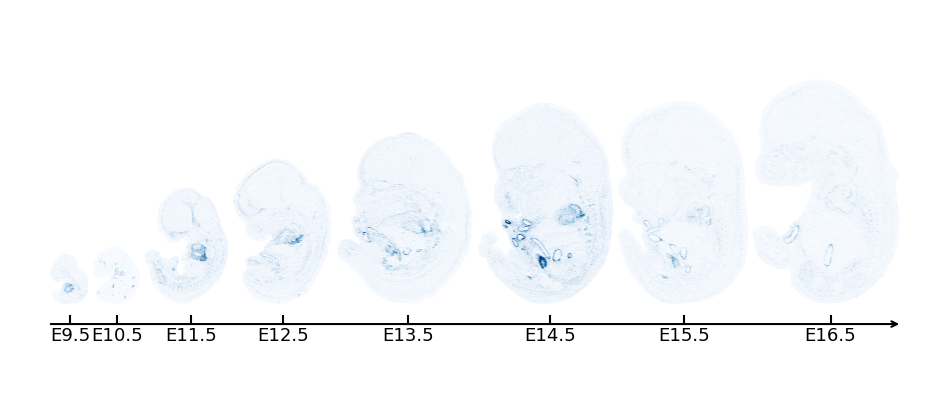

In [10]:
fig = plt.figure(figsize=(12,5))
size = 2.

ax0 = fig.add_subplot(1, 1, 1)
ax0.axis('equal')
x_coor = adata.obsm["spatial"][:, 0] 
y_coor = adata.obsm["spatial"][:, 1]
ax0.scatter(x_coor, -y_coor, s=size, rasterized=True, c=np.array(adata.obs["Myl9_val"].values).reshape(-1), cmap="Blues", vmax=30)

y_arrow = 168
ax0.annotate("", xy=(max(loc_list[0][:,0])+10, y_arrow), xytext=(min(loc_list[-1][:,0])-10, y_arrow), arrowprops=dict(arrowstyle="->", lw=1.5))
for i in range(len(loc_list)):
    x_m = np.median(loc_list[i][:, 0])
    plt.vlines(x = x_m, ymin=y_arrow, ymax=y_arrow+20, color = 'k')
    e_val = slice_name_list[i].split("_")[0]
    plt.annotate(e_val, xy=(x_m, y_arrow-40), ha='center', fontsize=13)

ax0.set_axis_off()
plt.ylim(150, 750)
plt.show()